# Bouldering Highlights

Create a video highlights from a bouldering competition video.  
Development notebook.


## 2. Split a video into 'Bouldering' sections

### Read the video file

In [ ]:
from src.bouldering.media.video.video import Video

# 1. Read the input video
VIDEO_PATH = "../data/video.mp4"
video = Video.read(VIDEO_PATH)
print(video.metadata)

sequence = video.sequence
fps = video.sequence.fps
frame_shape = video.sequence.frame(0).shape
H = frame_shape[0]

{'video': {'fps': 25.0, 'n_frames': 10500, 'resolution': (1280, 720)}, 'audio': {'sample_rate': 44100, 'duration': 420.0025396825397}}


### Split into Bouldering sections
- Sections are split by "Boulder" and by "scene"

In [ ]:
from src.bouldering.models.ocr.splitter import SceneSplitterOCR
from src.bouldering.structure.scenes.ocr import OCRSplitter
from src.bouldering.structure.scenes.content import ContentSplitter
from src.bouldering.structure.scenes.pipelines import ScenePipeline

# OCR splitter
ocr_logic = SceneSplitterOCR(
    langs=["en"],
    crop_box=[0, 0.5, 0.5, 1],  # <-- relative coords
    fx=0.5,
    fy=0.5,
    stride=3,
    batch_size=16,
    smooth_window=5,
    majority_ratio=0.6,
    require_number=True,
)

ocr_splitter = OCRSplitter(ocr_logic)

# Content splitter
content_splitter = ContentSplitter(
    threshold=27.0,
    min_scene_len_sec=1.5,
    downscale=2,
)

# Wrapper pipeline
pipeline = ScenePipeline(
    macro_splitter=ocr_splitter,
    micro_splitter=content_splitter,
)

# run the pipeline
scenes = pipeline.run(video)

/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

OCR scene splitting: 100%|██████████| 10500/10500 [01:03<00:00, 166.05frame/s]
INFO:pyscenedetect:Detecting scenes...
INFO:pyscenedetect:Detecting scenes...
INFO:pyscenedetect:Detecting scenes...
INFO:pyscenedetect:Detecting scenes...


Check detected sections

In [ ]:
scenes

[Scene(start_time=20.4, end_time=31.84, label='boulder_1', metadata={'parent': Scene(start_time=20.4, end_time=69.36, label='boulder_1', metadata={'source': 'ocr'}), 'source': 'ocr+content'}),
 Scene(start_time=31.84, end_time=48.6, label='boulder_1', metadata={'parent': Scene(start_time=20.4, end_time=69.36, label='boulder_1', metadata={'source': 'ocr'}), 'source': 'ocr+content'}),
 Scene(start_time=48.6, end_time=51.88, label='boulder_1', metadata={'parent': Scene(start_time=20.4, end_time=69.36, label='boulder_1', metadata={'source': 'ocr'}), 'source': 'ocr+content'}),
 Scene(start_time=51.88, end_time=59.68, label='boulder_1', metadata={'parent': Scene(start_time=20.4, end_time=69.36, label='boulder_1', metadata={'source': 'ocr'}), 'source': 'ocr+content'}),
 Scene(start_time=59.68, end_time=69.36, label='boulder_1', metadata={'parent': Scene(start_time=20.4, end_time=69.36, label='boulder_1', metadata={'source': 'ocr'}), 'source': 'ocr+content'}),
 Scene(start_time=69.36, end_time

we will choose a section as an example for this notebook

In [ ]:
scene = scenes[1]
video_part = video.cut(scene.start_time, scene.end_time)
sequence = video_part.sequence

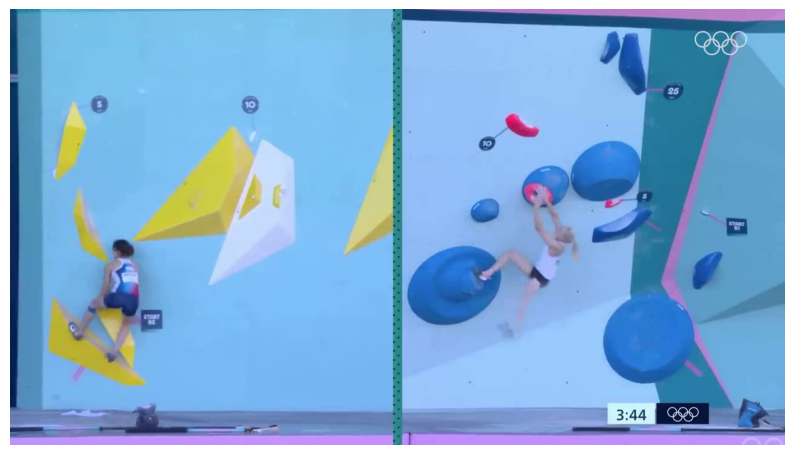

In [ ]:
import random
from src.bouldering.visualization.detection import plot_frame

i = random.randint(0, sequence.n_frames - 1)
frame = sequence.frame(i)
plot_frame(frame)

## 3. Detect competitors (detect and track)

In [ ]:
# detect persons
from src.bouldering.tracking.tracking import YoloPersonTracker
from src.bouldering.models.detection.yolo import YoloPersonDetector
from src.bouldering.tracking.postprocessing import merge_tracks
from src.bouldering.tracking.activity import detect_active_competitors

model = YoloPersonDetector()
tracker = YoloPersonTracker(model, fps=fps)
tracks = tracker.track_frames(sequence.frames())

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


419it [00:44,  9.43it/s]


Detect active competitors (moving persons)

In [ ]:
# postprocess detected tracks
merged_tracks = merge_tracks(tracks, frame_shape)
# for each tracked person, detect the active competitors
active_tracks = detect_active_competitors(
    tracks=merged_tracks,
    frame_shape=video.sequence.frame(0).shape,
    fps=video.sequence.fps,
    window_seconds=5.0,
    min_motion=0.002,
    min_presence=0.3,
)

In [ ]:
print("number of competitors:", len(active_tracks))

number of competitors: 2


## 4. Pose estimation

In [ ]:
# pose estimation
from src.bouldering.models.pose.pose import MediaPipePoseEstimator

pose_estimator = MediaPipePoseEstimator()

# pose estimation
track_id = 1
# pose detection

pose_tracks = {}

pose_tracks[track_id] = []
for entry in active_tracks[track_id]:
    frame = sequence.frame(entry["frame"])
    bbox = entry["bbox"].as_xyxy()

    landmarks = pose_estimator.estimate(frame, bbox)

    if landmarks is None:
        continue

    pose_tracks[track_id].append(
        {
            "frame": entry["frame"],
            "time": entry["frame"] / video.sequence.fps,
            "landmarks": landmarks,
        }
    )

Example of pose estimation output

In [ ]:
# sanity check
# sanity check: pose tracks structure
# Pick one active competitor
pose_track = pose_tracks[track_id]

print(f"Track ID: {track_id}")
print(f"Number of pose frames: {len(pose_track)}")

# Inspect first pose frame
pose_track[0]


Track ID: 1
Number of pose frames: 262


{'frame': 0,
 'time': 0.0,
 'landmarks': {'nose': (1026.7202033996582,
   426.86722457408905,
   0.9722360372543335),
  'left_eye_inner': (1024.994585633278, 409.55053627491, 0.972724974155426),
  'left_eye': (1028.6302237510681, 408.56470465660095, 0.9751741290092468),
  'left_eye_outer': (1032.3250513076782,
   407.60539650917053,
   0.9768491387367249),
  'right_eye_inner': (1016.075584769249,
   413.83769154548645,
   0.9613909125328064),
  'right_eye': (1012.2812806367874, 414.72245037555695, 0.9603092074394226),
  'right_eye_outer': (1008.8768861293793,
   415.72999358177185,
   0.9571401476860046),
  'left_ear': (1040.799088716507, 412.9181569814682, 0.9811970591545105),
  'right_ear': (1005.837587594986, 422.20225512981415, 0.9620909094810486),
  'mouth_left': (1037.3727719783783, 437.73668706417084, 0.9748048186302185),
  'mouth_right': (1023.7894441485405, 442.5636798143387, 0.9588833451271057),
  'left_shoulder': (1086.5450422763824,
   470.36155581474304,
   0.9313073754310

Plot pose landmarks

In [ ]:
# plmot pose landmarks
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, List

from src.bouldering.visualization.detection import plot_frame_with_landmarks, plot_frames_and_curve

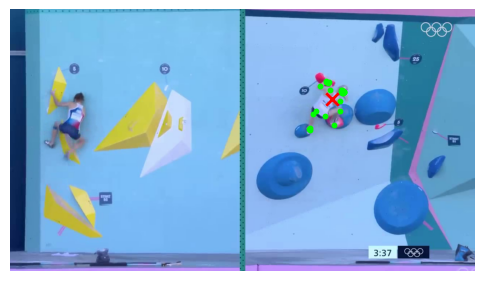

In [ ]:
# plot landmarks
idx = np.random.choice(len(pose_track))
frame = video_part.sequence.frame(pose_track[idx]["frame"])
landmarks = pose_track[idx]["landmarks"]

plot_frame_with_landmarks(frame, landmarks)

### 5. Visual features (from pose estimation)

Competitor position = Center of gravity (in y axis)

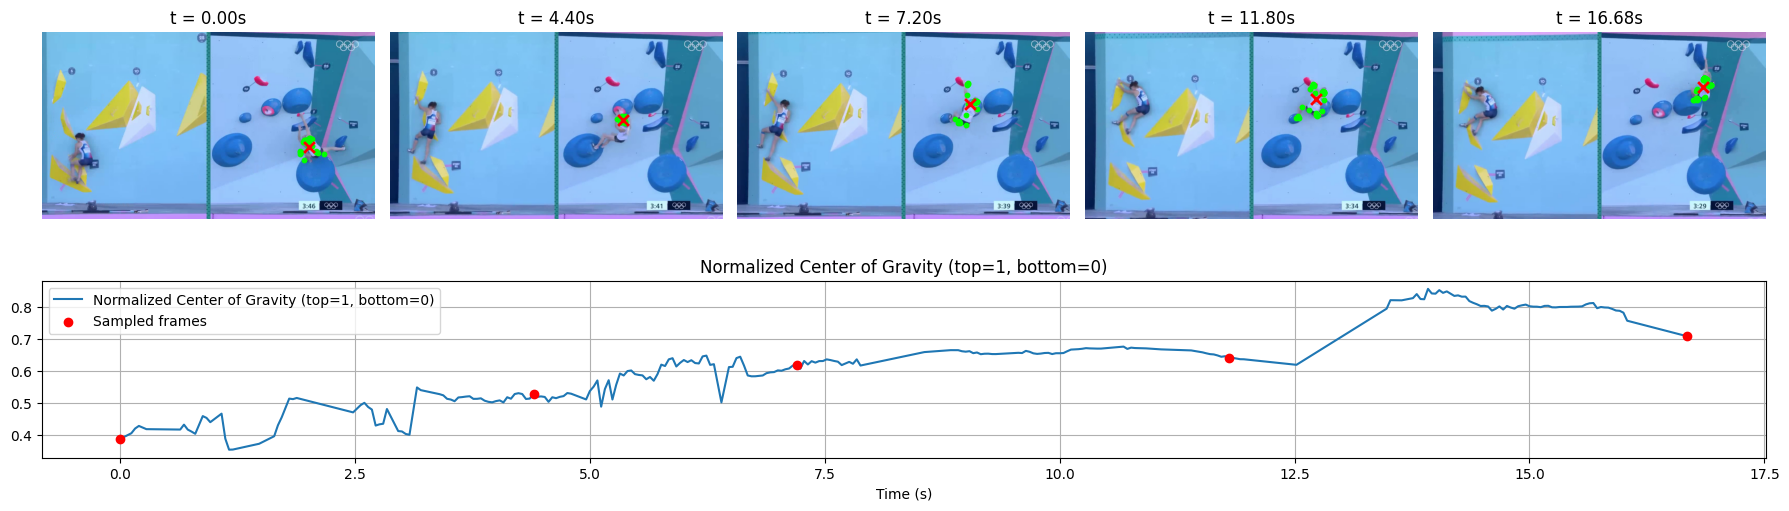

In [ ]:
from src.bouldering.features.pose import cog_y
from src.bouldering.features.motion import time_derivative
from src.bouldering.features.temporal import sliding_window, displacement_amplitude

# Build signals
cog_y_norm = [
    (
        f["time"],
        1.0 - (cog_y(f) / H) if cog_y(f) is not None else None
    )
    for f in pose_track
]

# --------------------------------------------------
# 2. Normalized vertical velocity (upward = positive)
# --------------------------------------------------
cog_velocity_norm = time_derivative(cog_y_norm)

# --------------------------------------------------
# 3. Normalized displacement amplitude
# --------------------------------------------------
windows = sliding_window(
    [(t, y) for t, y in cog_y_norm if y is not None],
    window_seconds=0.5,
)

amplitude_norm = [
    (w[-1][0], displacement_amplitude(w))
    for w in windows if len(w) > 1
]

# --------------------------------------------------
# 4. Plot (example: normalized CoG)
# --------------------------------------------------
plot_frames_and_curve(
    video=video_part,
    pose_track=pose_track,
    curve=cog_y_norm,
    curve_name="Normalized Center of Gravity (top=1, bottom=0)",
    n_samples=5,
)

Competitor velocity : in y axis

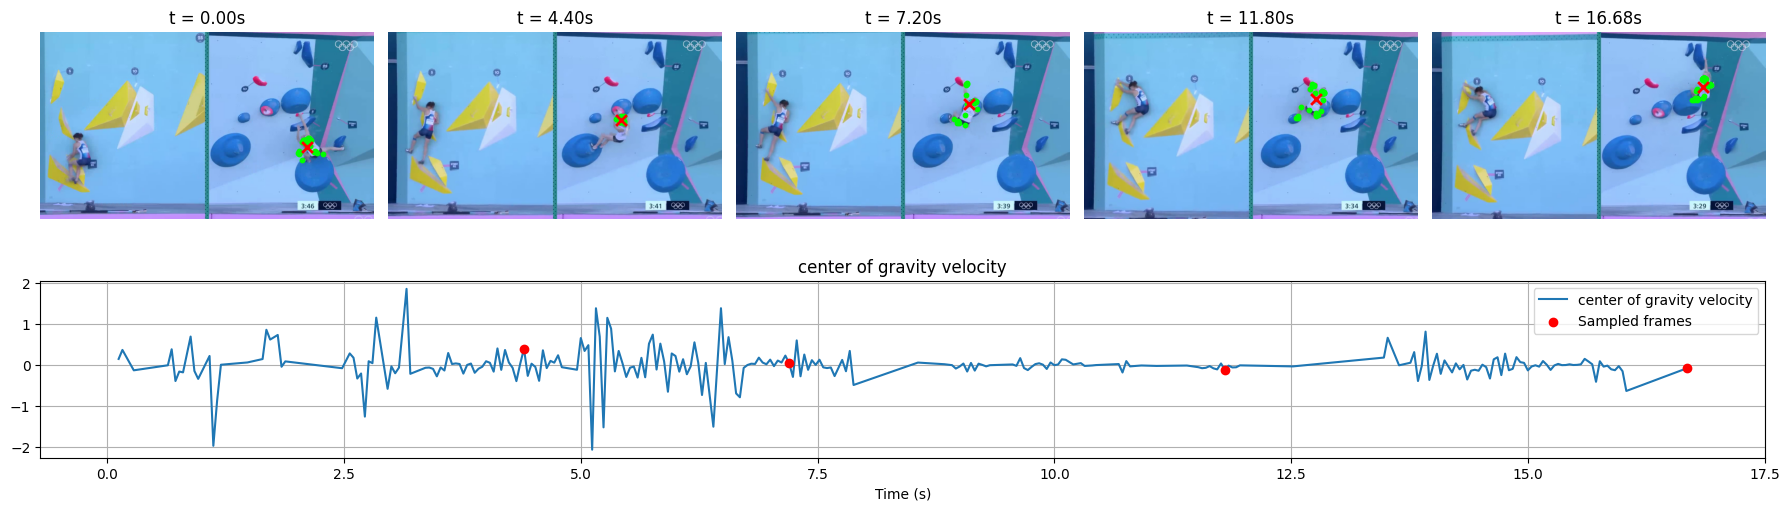

In [ ]:
plot_frames_and_curve(
    video=video_part,
    pose_track=pose_track,
    curve=cog_velocity_norm,
    curve_name="center of gravity velocity",
    n_samples=5,
)

Competitor displacement amplitude (between consecutive frames)

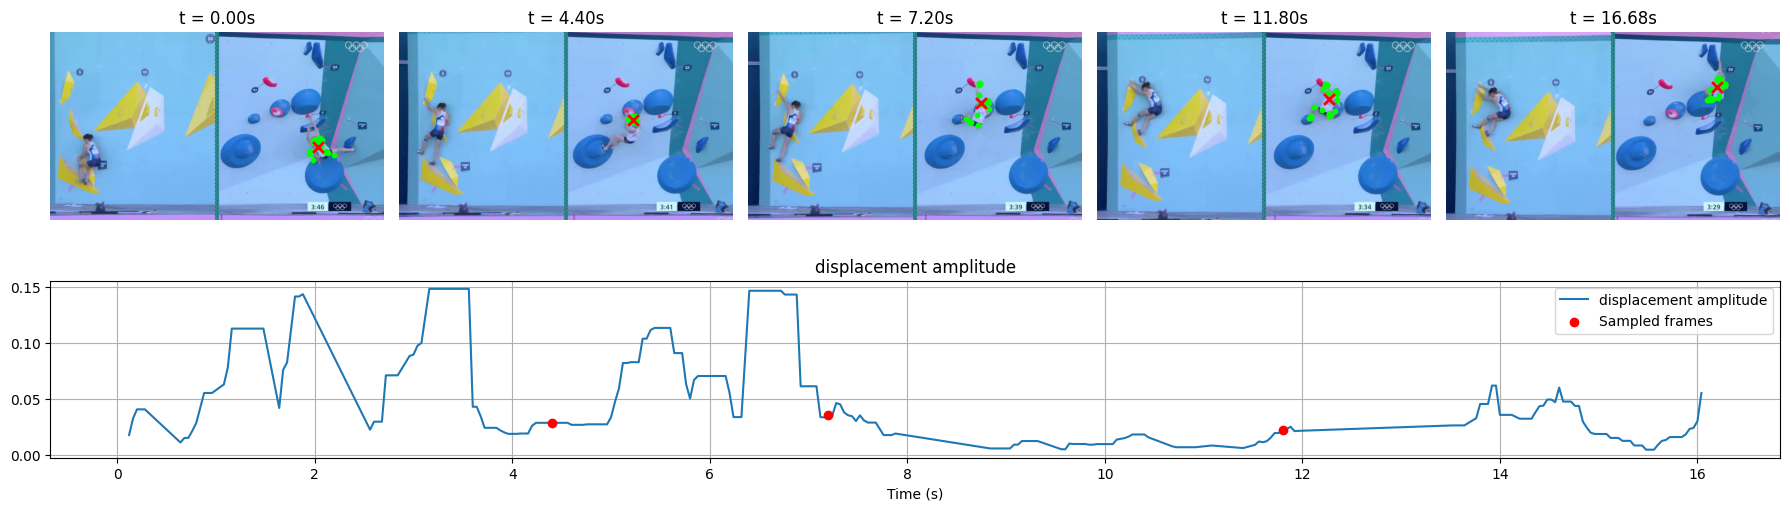

In [ ]:
plot_frames_and_curve(
    video=video_part,
    pose_track=pose_track,
    curve=amplitude_norm,
    curve_name="displacement amplitude",
    n_samples=5,
)

**Conclusion**:
- using the position of the competitor (particularly in y axis), it is possible de detect the most important moves (like a fall or a jump),
- we will detect special bouldering moves using these spatial features

Detection events:

In [ ]:
# now let's detect events (fall, dyno, top, crux)
import matplotlib.pyplot as plt

from src.bouldering.features.events import detect_top, detect_crux, detect_fall, detect_dyno
from src.bouldering.features.pose import cog_y, hands_above_shoulders, pose_visibility_ratio, normalize_cog_y
from src.bouldering.features.motion import time_derivative
from src.bouldering.features.temporal import sliding_window, displacement_amplitude

In [ ]:

# build core feature signals
# CoG Y
cog_y_norm = [(f["time"], normalize_cog_y(cog_y(f), H)) for f in pose_track]

# CoG velocity
cog_velocity_norm = time_derivative(cog_y_norm)

# CoG acceleration
cog_acceleration_norm = time_derivative(cog_velocity_norm)

# Pose visibility
visibility = [(f["time"], pose_visibility_ratio(f)) for f in pose_track]

# Hands above head
hands_up = [(f["time"], hands_above_shoulders(f)) for f in pose_track]


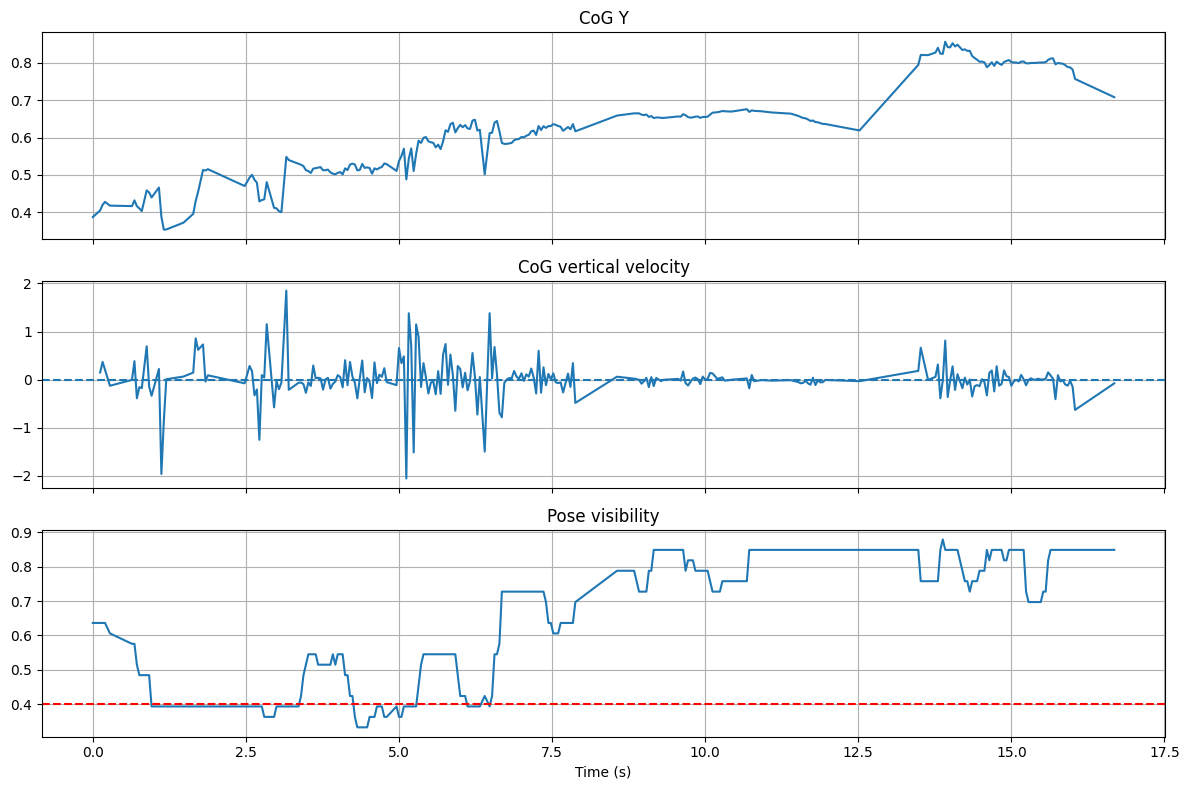

In [ ]:
# plot core signals
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# CoG Y
ax[0].plot(
    [t for t, v in cog_y_norm if v is not None],
    [v for t, v in cog_y_norm if v is not None],
)
ax[0].set_title("CoG Y")

# Velocity
ax[1].plot(
    [t for t, v in cog_velocity_norm if v is not None],
    [v for t, v in cog_velocity_norm if v is not None],
)
ax[1].axhline(0, linestyle="--")
ax[1].set_title("CoG vertical velocity")

# Visibility
ax[2].plot(
    [t for t, v in visibility if v is not None],
    [v for t, v in visibility if v is not None],
)
ax[2].axhline(0.4, color="red", linestyle="--")
ax[2].set_title("Pose visibility")

for a in ax:
    a.grid(True)

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()


### Event detection: Fall

In [ ]:
# fall detection
falls = detect_fall(
    velocity_norm=cog_velocity_norm,
    cog_y_norm=cog_y_norm,
    visibility=visibility,
    velocity_threshold=-0.3,
    ground_threshold=0.3,
    min_duration=0.2,
)

In [ ]:
print(len(falls))

0


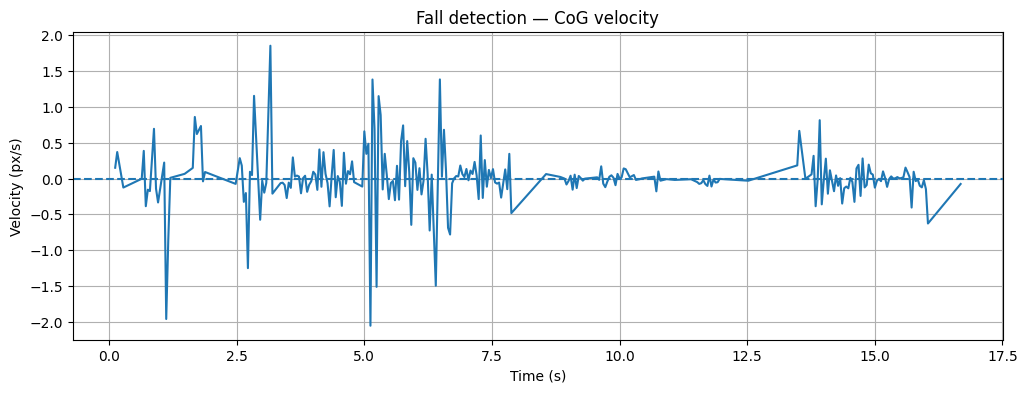

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(
    [t for t, v in cog_velocity_norm if v is not None],
    [v for t, v in cog_velocity_norm if v is not None],
)
plt.axhline(0, linestyle="--")

for event in falls:
    plt.axvspan(
        event["start"],
        event["end"],
        color="red",
        alpha=0.3,
        label="FALL"
    )

plt.title("Fall detection — CoG velocity")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (px/s)")
plt.grid(True)
plt.show()


### Event detection: Dyno

In [ ]:
# Displacement amplitude (normalized, 0–1)
windows = sliding_window(
    [(t, y) for t, y in cog_y_norm if y is not None],
    window_seconds=0.5,
)

displacement_amplitude_norm = [
    (w[-1][0], displacement_amplitude(w))
    for w in windows if len(w) > 1
]

dynos = detect_dyno(
    velocity_norm=cog_velocity_norm,
    acceleration_norm=cog_acceleration_norm,
    displacement_amplitude_norm=displacement_amplitude_norm,
    min_velocity=0.25,        # strong upward motion
    min_acceleration=2.0,     # explosive
    min_amplitude=0.08,       # large vertical displacement
    max_duration=0.6,
)

print(len(dynos))

7


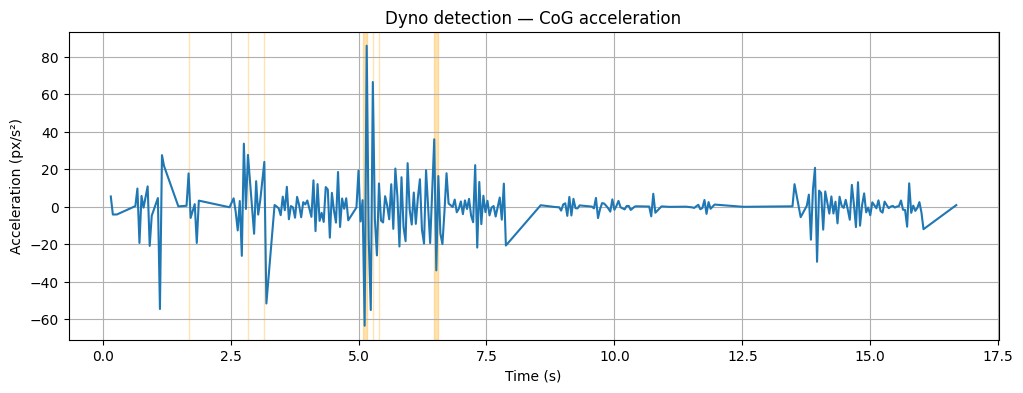

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(
    [t for t, v in cog_acceleration_norm if v is not None],
    [v for t, v in cog_acceleration_norm if v is not None],
)

for event in dynos:
    plt.axvspan(
        event["start"],
        event["end"],
        color="orange",
        alpha=0.3,
        label="DYNO"
    )

plt.title("Dyno detection — CoG acceleration")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (px/s²)")
plt.grid(True)
plt.show()


we can filter events by minimum duration

### Event detection: Crux

In [ ]:
# crux detection
# Motion energy proxy = |velocity|
# Motion variance (from velocity)
motion_windows = sliding_window(
    [(t, v) for t, v in cog_velocity_norm if v is not None],
    window_seconds=2.0,
)

motion_variance = [
    (w[-1][0], np.var([v for _, v in w]))
    for w in motion_windows if len(w) > 1
]

# Vertical progress (from CoG)
progress_windows = sliding_window(
    [(t, y) for t, y in cog_y_norm if y is not None],
    window_seconds=2.0,
)

vertical_progress = [
    (w[-1][0], max(y for _, y in w) - min(y for _, y in w))
    for w in progress_windows if len(w) > 1
]

In [ ]:
cruxes = detect_crux(
    motion_variance=motion_variance,
    vertical_progress=vertical_progress,
    min_duration=2.5,
    max_progress=0.15,
)

print(len(cruxes))

0


### Event detection: Top

In [ ]:
motion_energy = [
    (t, abs(v)) for t, v in cog_velocity_norm if v is not None
]

tops = detect_top(
    hands_above_shoulders=hands_up,
    cog_y_norm=cog_y_norm,
    motion_energy=motion_energy,
    top_threshold=0.75,   # near top
    max_motion=0.08,      # stable
    min_duration=0.1,
)

print("Tops:")
tops

Tops:


[{'type': 'TOP',
  'start': 13.52,
  'end': 13.64,
  'duration': 0.120000000000001,
  'confidence': 1.0},
 {'type': 'TOP',
  'start': 14.88,
  'end': 15.08,
  'duration': 0.1999999999999993,
  'confidence': 1.0},
 {'type': 'TOP',
  'start': 15.64,
  'end': 16.04,
  'duration': 0.3999999999999986,
  'confidence': 1.0}]

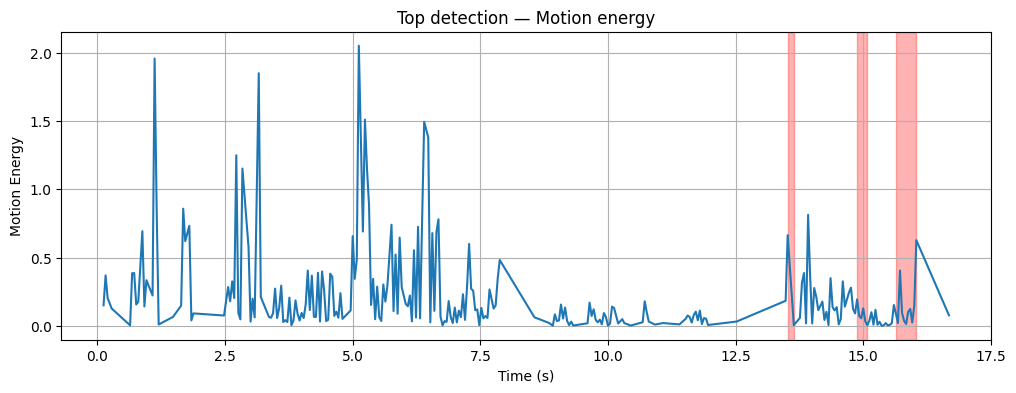

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(
    [t for t, v in motion_energy if v is not None],
    [v for t, v in motion_energy if v is not None],
)

for event in tops:
    plt.axvspan(
        event["start"],
        event["end"],
        color="red",
        alpha=0.3,
        label="DYNO"
    )

plt.title("Top detection — Motion energy")
plt.xlabel("Time (s)")
plt.ylabel("Motion Energy")
plt.grid(True)
plt.show()


## 5. Audio features
We can use audio to detect special events. We can build audio features based on crow sheering because it's highly related to important events happening.

Detect crowd sheering: YamNet model
we will use yamnet to detect if the crowd is sheering

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from src.bouldering.features.audio import AudioFeatures
from src.bouldering.features.audio_semantics import crowd_prediction
from src.bouldering.models.audio.yamnet import YamNetClassifier
from src.bouldering.features.audio import resample_waveform, rms_energy, apply_filter, zscore_signal, delta_signal


In [ ]:
audio = video_part.audio.samples          # raw waveform (mono or stereo)
sr = video_part.audio.sample_rate           # original sampling rate

print(f"Original sample rate: {sr} Hz")
print(f"Audio duration: {len(audio) / sr:.2f} s")


Original sample rate: 44100 Hz
Audio duration: 16.76 s


In [ ]:
# YamNet predictions
model = YamNetClassifier()

waveform_16k = resample_waveform(audio, sr, 16000)

scores, embeddings, spectrogram = model.model(waveform_16k)
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = model.class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')


The main sound is: Speech


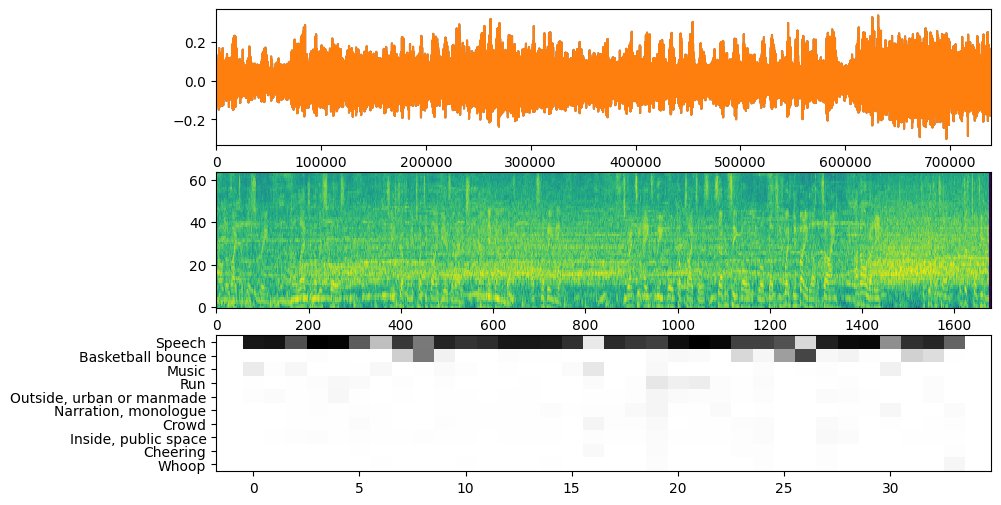

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(audio)
plt.xlim([0, len(audio)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [model.class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))


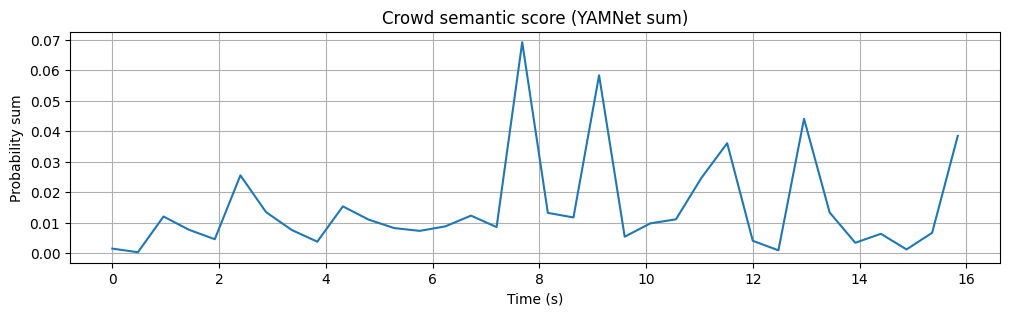

In [ ]:

yamnet_output = model.predict(waveform_16k, 16000)

crowd_score = crowd_prediction(
    yamnet_output,
    target_classes=("Crowd", "Cheering", "Shout"),
)

plt.figure(figsize=(12, 3))
plt.plot(
    [t for t, v in crowd_score],
    [v for t, v in crowd_score],
)
plt.title("Crowd semantic score (YAMNet sum)")
plt.xlabel("Time (s)")
plt.ylabel("Probability sum")
plt.grid(True)
plt.show()

**Conclusion**:
- The audio contains commentator speech all along the track, the model yamnet is mainly predicting the class Speech, however we can maybe use the probabilities of the classes 'crowd' and 'cheering'
- The spectrogram shows that the speech is mainly in the frequency band [0 - 500 Hz]. Then it's more influenced by the crowd. We can then filter the signal using a high pass filter and monitor the crowd's noise.

filter audio

In [ ]:
window = 400e-3  # 400 ms
f = 500  # Hz
filtered_audio = apply_filter(audio, sr, filter_type="highpass", low_hz=f)
rms = rms_energy(filtered_audio, sr, window_seconds=window)
delta_rms = delta_signal(rms)
z_rms = zscore_signal(rms)

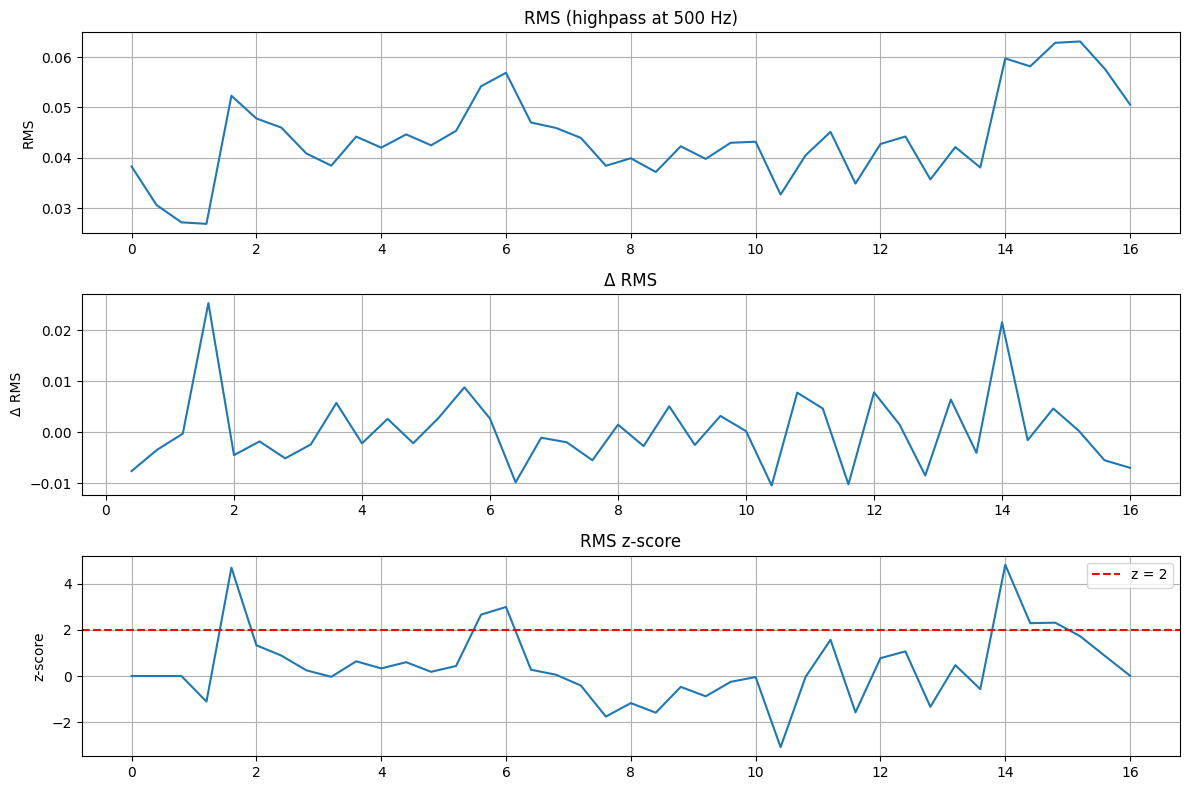

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot([t for t, v in rms], [v for t, v in rms])
plt.title(f"RMS (highpass at {f} Hz)")
plt.ylabel("RMS")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot([t for t, v in delta_rms], [v for t, v in delta_rms])
plt.title("Δ RMS")
plt.ylabel("Δ RMS")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot([t for t, v in z_rms], [v for t, v in z_rms])
plt.axhline(2.0, color="red", linestyle="--", label="z = 2")
plt.title("RMS z-score")
plt.ylabel("z-score")
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

**Conclusion**:
- The audio features can be a robust indicator,
- we can filter the commentator's speech by a high pass filter and monitor the crowd's noise (very correlated with important moves)

## 6. Scores
- Now, we will use the visual and the audio features to compute scores and extract highlights from the video:
- The idea is to compute an audio score and a visual score, and then make weighted sum to get an overall score. Detected events will be used to enhance scores around those events.

### Visual score
We will define the following scores:
- **upward movement score**: track positive vertical velocity (using positive velocity)
- **dynamic motion score**: captures instabilities (dynos, falls) (using absolute velocity)
- **sustained effort**: hard sections, high movement (crux)


In [ ]:
from src.bouldering.scoring.visual import compute_visual_score
from src.bouldering.scoring.utils import fill_none_with_zero, interpolate_signal

In [ ]:
# Build signals
cog_y_norm = [
    (
        f["time"],
        1.0 - (cog_y(f) / H) if cog_y(f) is not None else None
    )
    for f in pose_track
]

# --------------------------------------------------
# 2. Normalized vertical velocity (upward = positive)
# --------------------------------------------------
cog_velocity_norm = time_derivative(cog_y_norm)

# --------------------------------------------------
# 3. Normalized displacement amplitude
# --------------------------------------------------
windows = sliding_window(
    [(t, y) for t, y in cog_y_norm if y is not None],
    window_seconds=0.5,
)

amplitude_norm = [
    (w[-1][0], displacement_amplitude(w))
    for w in windows if len(w) > 1
]

In [ ]:
frame_times = [t for t, _ in cog_velocity_norm]

amplitude_interp = interpolate_signal(
    amplitude_norm,
    frame_times,
)

In [ ]:
cog_velocity_clean = fill_none_with_zero(cog_velocity_norm)
amplitude_clean = fill_none_with_zero(amplitude_interp)


In [ ]:
visual_score = compute_visual_score(
    v_y_signal=cog_velocity_clean,
    displacement_signal=amplitude_clean,
    weights=(0.3, 0.5, 0.2),
)

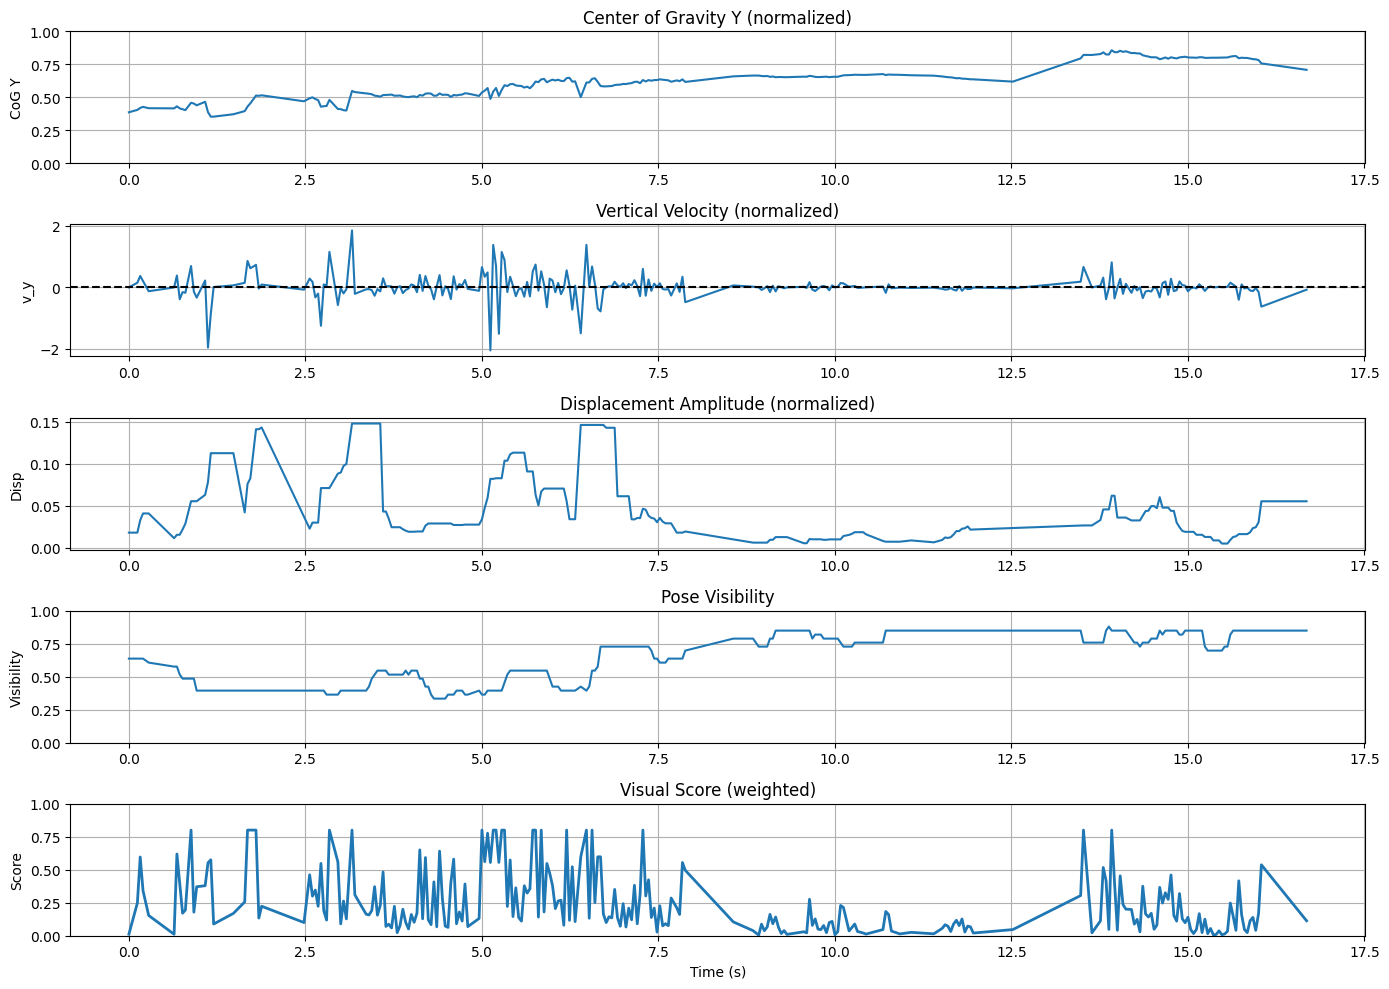

In [ ]:

plt.figure(figsize=(14, 10))

# --- CoG Y position ---
plt.subplot(5, 1, 1)
plt.plot(
    [t for t, v in cog_y_norm],
    [v for t, v in cog_y_norm],
)
plt.title("Center of Gravity Y (normalized)")
plt.ylabel("CoG Y")
plt.ylim(0, 1)
plt.grid(True)

# --- Vertical velocity ---
plt.subplot(5, 1, 2)
plt.plot(
    [t for t, v in cog_velocity_clean],
    [v for t, v in cog_velocity_clean],
)
plt.axhline(0, color="black", linestyle="--")
plt.title("Vertical Velocity (normalized)")
plt.ylabel("v_y")
plt.grid(True)

# --- Displacement ---
plt.subplot(5, 1, 3)
plt.plot(
    [t for t, v in amplitude_clean],
    [v for t, v in amplitude_clean],
)
plt.title("Displacement Amplitude (normalized)")
plt.ylabel("Disp")
plt.grid(True)

# --- Pose visibility ---
plt.subplot(5, 1, 4)
plt.plot(
    [t for t, v in visibility],
    [v for t, v in visibility],
)
plt.title("Pose Visibility")
plt.ylabel("Visibility")
plt.ylim(0, 1)
plt.grid(True)

# --- Visual score ---
plt.subplot(5, 1, 5)
plt.plot(
    [t for t, v in visual_score],
    [v for t, v in visual_score],
    linewidth=2,
)
plt.title("Visual Score (weighted)")
plt.xlabel("Time (s)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()

### Audio score
We will define the following scores:
- **RMS reactivity**: sound energy (main features)
- **Relative loudness**: avoids harsh thresholds
- **crowd hint**: using yamnet crowd probability


In [ ]:
from src.bouldering.scoring.utils import clamp, sigmoid
from src.bouldering.scoring.audio import compute_audio_score

In [ ]:
window = 0.48  # 400 ms
f = 500  # Hz
filtered_audio = apply_filter(audio, sr, filter_type="highpass", low_hz=f)
rms = rms_energy(filtered_audio, sr, window_seconds=window)
delta_rms = delta_signal(rms)
z_rms = zscore_signal(rms)

In [ ]:
# use same as visual times
visual_times = [t for t, _ in cog_velocity_clean]


In [ ]:
delta_rms_interp = interpolate_signal(delta_rms, visual_times)
z_rms_interp = interpolate_signal(z_rms, visual_times)
crowd_interp = interpolate_signal(crowd_score, visual_times)


In [ ]:
audio_score = compute_audio_score(
    delta_rms_signal=delta_rms_interp,
    z_rms_signal=z_rms_interp,
    crowd_signal=crowd_interp,
)


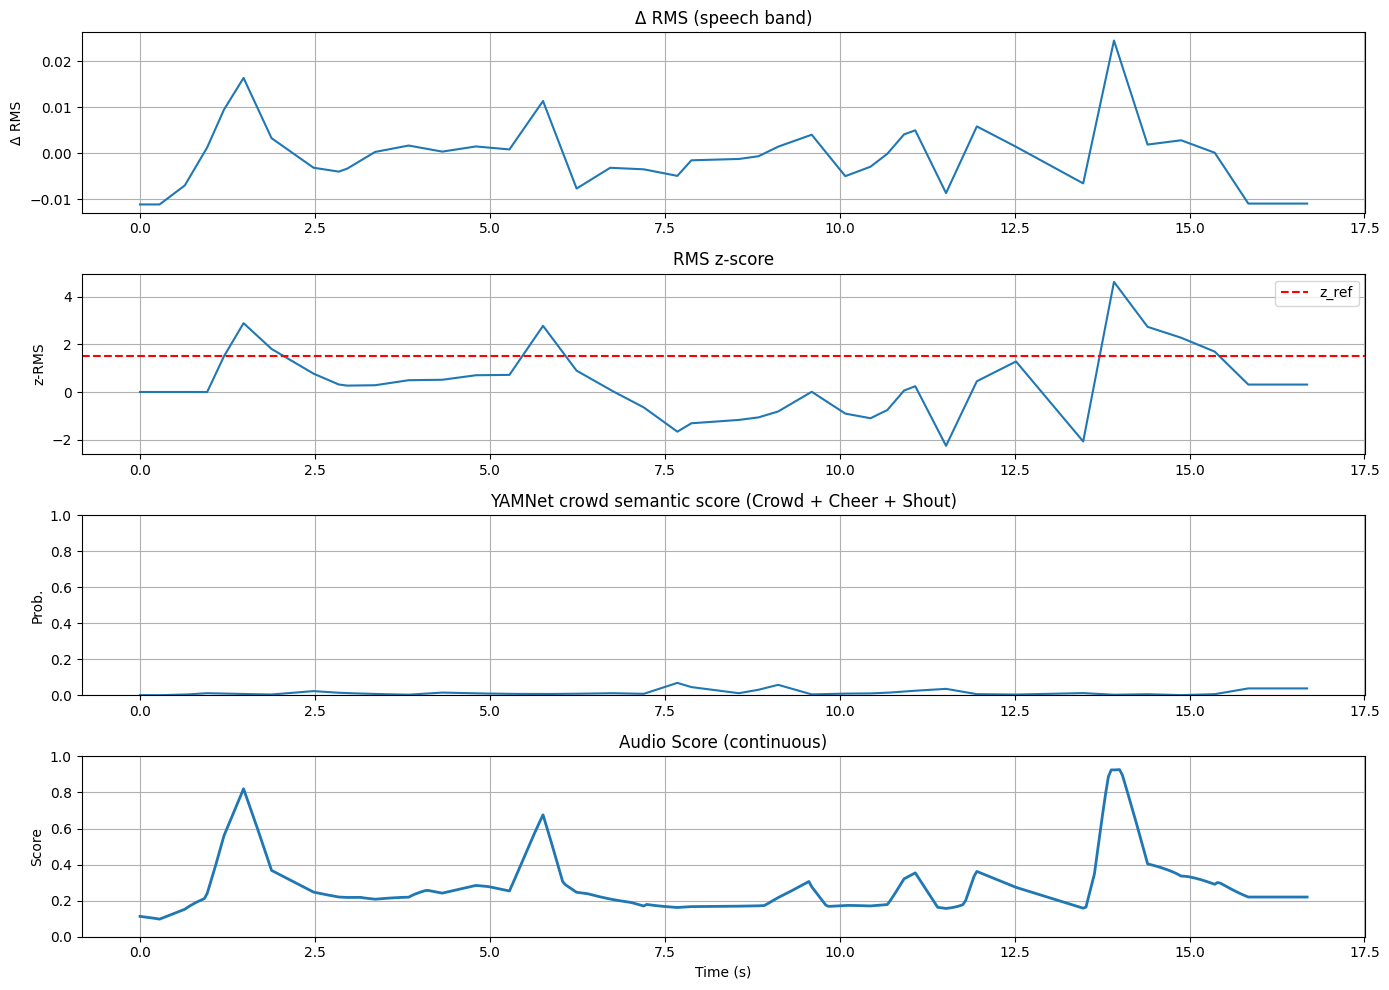

In [ ]:
# ============================================
# 4. Plot audio features and audio score
# ============================================

plt.figure(figsize=(14, 10))

# --- ΔRMS ---
plt.subplot(4, 1, 1)
plt.plot(
    [t for t, v in delta_rms_interp],
    [v for t, v in delta_rms_interp],
)
plt.title("Δ RMS (speech band)")
plt.ylabel("Δ RMS")
plt.grid(True)

# --- z-RMS ---
plt.subplot(4, 1, 2)
plt.plot(
    [t for t, v in z_rms_interp],
    [v for t, v in z_rms_interp],
)
plt.axhline(1.5, color="red", linestyle="--", label="z_ref")
plt.title("RMS z-score")
plt.ylabel("z-RMS")
plt.legend()
plt.grid(True)

# --- YAMNet crowd semantic ---
plt.subplot(4, 1, 3)
plt.plot(
    [t for t, v in crowd_interp],
    [v for t, v in crowd_interp],
)
plt.title("YAMNet crowd semantic score (Crowd + Cheer + Shout)")
plt.ylabel("Prob.")
plt.ylim(0, 1)
plt.grid(True)

# --- Audio score ---
plt.subplot(4, 1, 4)
plt.plot(
    [t for t, v in audio_score],
    [v for t, v in audio_score],
    linewidth=2,
)
plt.title("Audio Score (continuous)")
plt.xlabel("Time (s)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()


### Overall score (audio + visual)

In [ ]:
from src.bouldering.scoring.score import compute_overall_score

ALPHA = 0.65
BETA = 0.35

overall_score = compute_overall_score(audio_score, visual_score, ALPHA, BETA)

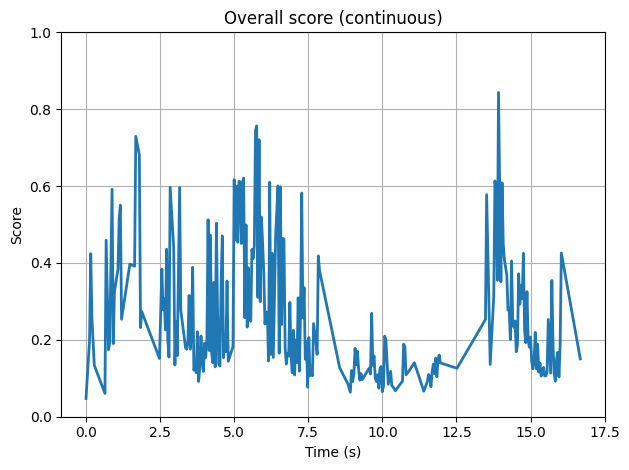

In [ ]:
plt.plot(
    [t for t, v in overall_score],
    [v for t, v in overall_score],
    linewidth=2,
)
plt.title("Overall score (continuous)")
plt.xlabel("Time (s)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.show()

### Score event boosting
- we will take the detected events (dyno, fall, crux, top) and use them to boost the score around them

In [ ]:
import numpy as np

EVENT_PARAMS = {
    "DYNO": {"tau": 0.35, "max_boost": 0.6},
    "FALL": {"tau": 0.35, "max_boost": 0.4},
    "CRUX": {"tau": 0.8,  "max_boost": 0.3},
    "TOP":  {"tau": 1.0,  "max_boost": 0.8},
}

In [ ]:
def event_boost(
    t: float,
    event_time: float,
    confidence: float,
    tau: float,
    max_boost: float,
) -> float:
    """
    Temporal boost generated by a single event.
    """
    return max_boost * confidence * np.exp(-abs(t - event_time) / tau)

In [ ]:
from src.bouldering.scoring.events import apply_event_boosts

all_events = []
all_events.extend(falls)
all_events.extend(dynos)
all_events.extend(cruxes)
all_events.extend(tops)

final_score = apply_event_boosts(
    overall_score,
    all_events,
    EVENT_PARAMS,
)

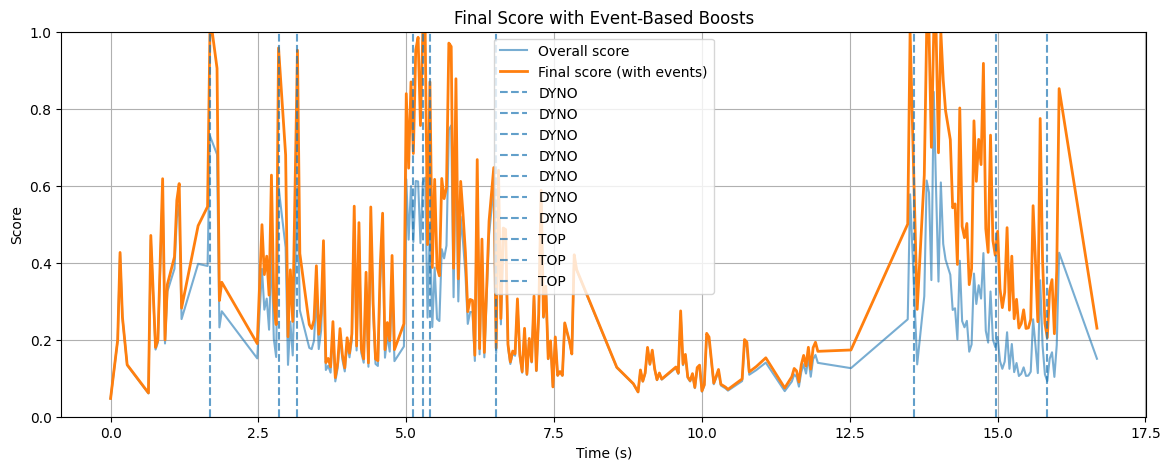

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.plot(
    [t for t, s in overall_score],
    [s for t, s in overall_score],
    label="Overall score",
    alpha=0.6,
)

plt.plot(
    [t for t, s in final_score],
    [s for t, s in final_score],
    label="Final score (with events)",
    linewidth=2,
)

for e in all_events:
    t_event = 0.5 * (e["start"] + e["end"])
    plt.axvline(
        t_event,
        linestyle="--",
        alpha=0.7,
        label=e["type"],
    )

plt.ylim(0, 1)
plt.xlabel("Time (s)")
plt.ylabel("Score")
plt.title("Final Score with Event-Based Boosts")
plt.legend()
plt.grid(True)
plt.show()


Smoothing the scoring curve

In [ ]:
# score smoothing "Exponential Moving average"
# ============================================
# 1. Smooth final score (EMA)
# ============================================

from src.bouldering.scoring.utils import ema_smooth

final_score_smooth = ema_smooth(final_score, alpha=0.25)


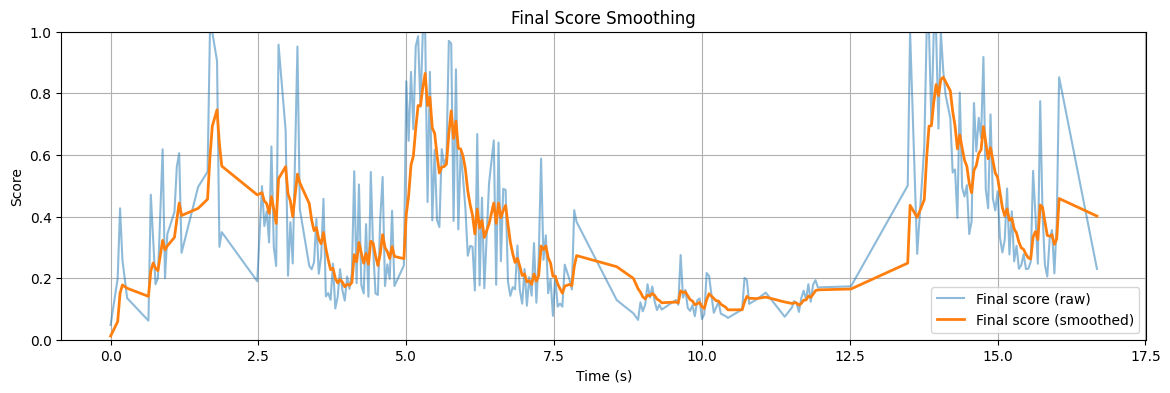

In [ ]:
# plot raw vs smoothed score
# ============================================
# 2. Plot smoothing effect
# ============================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))

plt.plot(
    [t for t, s in final_score],
    [s for t, s in final_score],
    label="Final score (raw)",
    alpha=0.5,
)

plt.plot(
    [t for t, s in final_score_smooth],
    [s for t, s in final_score_smooth],
    label="Final score (smoothed)",
    linewidth=2,
)

plt.ylim(0, 1)
plt.xlabel("Time (s)")
plt.ylabel("Score")
plt.title("Final Score Smoothing")
plt.legend()
plt.grid(True)
plt.show()


## 7. Extract highlights
Using the scoring curve, detect peaks (with their relative score)

In [ ]:
from src.bouldering.scoring.utils import detect_peaks

peaks = detect_peaks(
    final_score_smooth,
    min_height=0.45,
    min_distance=1.0,
)

print(f"Detected {len(peaks)} peaks")


Detected 5 peaks


In [ ]:
peaks

[{'time': 1.8, 'score': np.float64(0.7464788003210348)},
 {'time': 2.96, 'score': np.float64(0.56202378833875)},
 {'time': 5.2, 'score': np.float64(0.7605204867533096)},
 {'time': 13.96, 'score': np.float64(0.8283750428768077)},
 {'time': 16.04, 'score': np.float64(0.45850097921781674)}]

In [ ]:
from src.bouldering.scoring.utils import extract_segments
from src.bouldering.structure.segments.segments import merge_segments, rank_segments

segments = extract_segments(peaks, pre=1.5, post=2.5)
merged_segments = merge_segments(segments)
ranked_segments = rank_segments(merged_segments)

In [ ]:
merged_segments

[{'start': 0.30000000000000004,
  'end': 7.7,
  'peak_time': 1.8,
  'peak_score': np.float64(0.7605204867533096)},
 {'start': 12.46,
  'end': 18.54,
  'peak_time': 13.96,
  'peak_score': np.float64(0.8283750428768077)}]

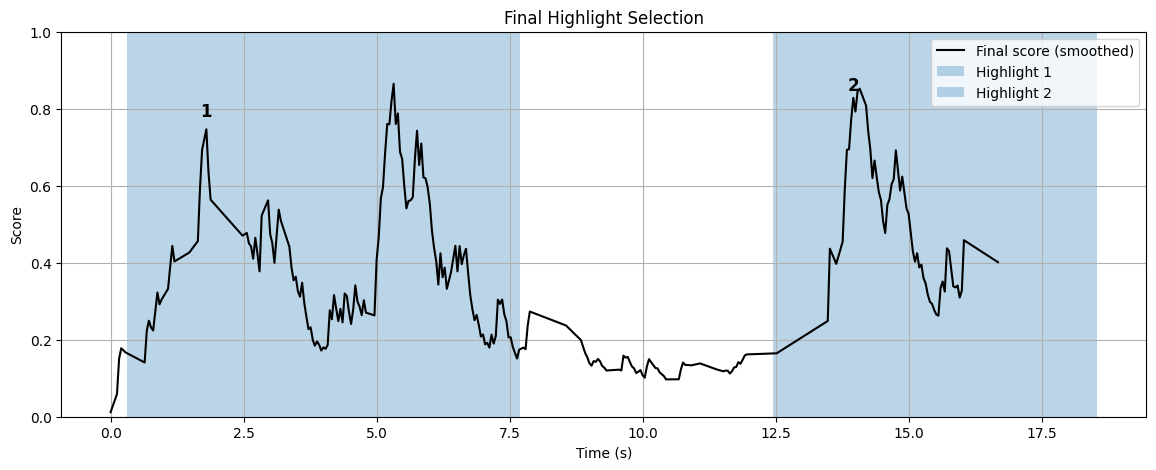

In [ ]:
# ============================================
# 7. Plot final highlights on score
# ============================================

plt.figure(figsize=(14, 5))

plt.plot(
    [t for t, s in final_score_smooth],
    [s for t, s in final_score_smooth],
    color="black",
    label="Final score (smoothed)",
)

for i, h in enumerate(ranked_segments):
    plt.axvspan(
        h["start"],
        h["end"],
        alpha=0.3,
        label=f"Highlight {i+1}",
    )
    plt.text(
        h["peak_time"],
        h["peak_score"] + 0.02,
        f"{i+1}",
        ha="center",
        fontsize=12,
        weight="bold",
    )

plt.ylim(0, 1)
plt.xlabel("Time (s)")
plt.ylabel("Score")
plt.title("Final Highlight Selection")
plt.legend()
plt.grid(True)
plt.show()


- Now, we can split the original video, cut through the detected segments, then concatenante them and save the highlights video.  
- We can adjust some parameters like the segment durations to control the highlights length